In [1]:
#import libraries
%matplotlib inline

import warnings
from collections import Counter
import numpy as np
warnings.filterwarnings('ignore')
import networkx as nx
import pandas as pd
from networkx.generators.community import LFR_benchmark_graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import plotly.graph_objects as go
from collections import Counter
import datetime
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
#import dataset, where the number indicates the timestamp
df1 = pd.read_csv("../data_collection/data/RW_Graphs/df_S1.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df2 = pd.read_csv("../data_collection/data/RW_Graphs/df_S2.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df3 = pd.read_csv("../data_collection/data/RW_Graphs/df_S3.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df4 = pd.read_csv("../data_collection/data/RW_Graphs/df_S4.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

In [3]:
def dict_bin(test_dict):
    '''Function that takes a dictionary of the form user:label as input and return 
    the same dictionary with the label binned in 4 bins'''
    res=dict()
    for key in test_dict: #iterate over the dictionary
        if test_dict[key]<0.25: res[key]=0 #if the value is less than 0.25, the label is set to 0
        if test_dict[key]>=0.25 and test_dict[key]<0.5: res[key]=0.25 #if the label is between 0.25 and 0.5, the label is set to 0.25
        if test_dict[key]>=0.5 and test_dict[key]<0.75: res[key]=0.5 #see above
        if test_dict[key]>=0.75: res[key]=1 #idem
    return res

  

In [4]:
#create data for sankey plot
def create_data(data,N):  
    '''Function used to format the data for the Sankey plot. 
    Input is a dataframe and the number of tweets each user must write 
    in a temporal window, output is a dictionary of the form user:label'''
    
    gb = data.groupby(['User']) #group all the tweets by user 
    counts = gb.size().to_frame(name='counts') #calculate how many tweets each user wrote
    #recalculate user_label: take the mean of all the tweet label for each user
    df1_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'}))
    
    #keep only the users that wrote at least N tweet 
    #N=0
    df1_sorted=df1_count.loc[(df1_count['counts'] >= N)]
    
    #create the dictionary of the form user:label
    df1_dict=pd.Series(df1_sorted.user_label.values,index=df1_sorted.index).to_dict()
    #bin the dictionary 
    df1_dict=dict_bin(df1_dict)
    return df1_dict

In [5]:
#create data, at least one tweet per user
df1_dict=create_data(df1,1)
df2_dict=create_data(df2,1)
df3_dict=create_data(df3,1)
df4_dict=create_data(df4,1)

In [6]:
#keep users that appears in every time stamp
'''idx = df1_sorted.index.intersection(df2_sorted.index)
df1_sorted = df1_sorted.loc[idx]
idx = df1_sorted.index.intersection(df3_sorted.index)
df1_sorted = df1_sorted.loc[idx]
idx = df1_sorted.index.intersection(df4_sorted.index)

df2_sorted = df2_sorted.loc[idx]
df1_sorted = df1_sorted.loc[idx]
df3_sorted = df3_sorted.loc[idx]
df4_sorted = df4_sorted.loc[idx]
print(idx)'''

'idx = df1_sorted.index.intersection(df2_sorted.index)\ndf1_sorted = df1_sorted.loc[idx]\nidx = df1_sorted.index.intersection(df3_sorted.index)\ndf1_sorted = df1_sorted.loc[idx]\nidx = df1_sorted.index.intersection(df4_sorted.index)\n\ndf2_sorted = df2_sorted.loc[idx]\ndf1_sorted = df1_sorted.loc[idx]\ndf3_sorted = df3_sorted.loc[idx]\ndf4_sorted = df4_sorted.loc[idx]\nprint(idx)'

In [7]:
#count how many users are in each bin at each timestamp
df1_dict_count=dict(Counter(df1_dict.values()))
df2_dict_count=dict(Counter(df2_dict.values()))
df3_dict_count=dict(Counter(df3_dict.values()))
df4_dict_count=dict(Counter(df4_dict.values()))

In [8]:
#list with size of every bin at each timestamp
count_nodes=[df1_dict_count[0],df1_dict_count[0.25],df1_dict_count[0.5],df1_dict_count[1],
               df2_dict_count[0],df2_dict_count[0.25],df2_dict_count[0.5],df2_dict_count[1],
               df3_dict_count[0],df3_dict_count[0.25],df3_dict_count[0.5],df3_dict_count[1],
               df4_dict_count[0],df4_dict_count[0.25],df4_dict_count[0.5],df4_dict_count[1]
              ]

In [9]:
def dict_compare(d1, d2):
    '''Function that compare two dictionaries of the form user:label and return
    a dictionary of the form (b1,b2): N, where N indicates the number of users 
    that moved from label b1 to label b2 (binned).'''
    #make sure to have unique values
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())    
    
    #get only shared keys, i.e. users that are in both timestamps
    shared_keys = d1_keys.intersection(d2_keys)
    #create temporary dictionary that indicates the movement of user o from label d1[o] to d2[o]
    modified = {o :(d1[o], d2[o]) for o in shared_keys} 
   
    #get list of the label movements in the form [(0,0),(0,0.5),etc...]
    modified=list(modified.values())

    #create a dictionary that counts how many changes there has been
    ao_dict=dict(Counter(modified))
    kk=[0,0.25,0.5,1]
    for i in kk:
        for j in kk:
            #initialize empty values of the dictionary if there is no movement from i to j
            ao_dict.setdefault((i,j), 0)

        
    return ao_dict

In [10]:
#compare time stamps 1-2, 2-3, 3-4
t01=dict_compare(df1_dict,df2_dict)
t12=dict_compare(df2_dict,df3_dict)
t23=dict_compare(df3_dict,df4_dict)

In [11]:
#create Sankey plot


# Nodes
nodes = [['ID', 'Label', 'Color'],
        [0,'0-0.25','#000793'], #time 0
        [1,'0.25-0.5','#49D8E8'],
        [2,'0.5-0.75','#EFCB1A'],
        [3,'0.75-1','#E80C0C'],
        [4,'0-0.25','#000793'], #time 1
        [5,'0.25-0.5','#49D8E8'],
        [6,'0.5-0.75','#EFCB1A'],
        [7,'0.75-1','#E80C0C'],
        [8,'0-0.25','#000793'], #time 2
        [9,'0.25-0.5','#49D8E8'],
        [10,'0.5-0.75','#EFCB1A'],
        [11,'0.75-1','#E80C0C'],
        [12,'0-0.25','#000793'], #time 3
        [13,'0.25-0.5','#49D8E8'],
        [14,'0.5-0.75','#EFCB1A'],
        [15,'0.75-1','#E80C0C'],
       ]



# define list of links 
links = [['Source','Target','Value','Link Color'],

        # from time 0 to time 1
        [0,4,t01[0,0],'rgba(5, 31, 223, 0.15)'], #from node 0 (0 at time 0) to node 4 (0 at time 1)
        [0,5,t01[0,0.25],'rgba(5, 31, 223, 0.15)'], #from node 0 (0 at time 0) to node 5 (0.25 at time 1)
        [0,6,t01[0,0.5],'rgba(5, 31, 223, 0.15)'], #and so on...
        [0,7,t01[0,1],'rgba(5, 31, 223, 0.15)'],

        [1,4,t01[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [1,5,t01[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [1,6,t01[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [1,7,t01[0.25,1],'rgba(170, 230, 242, 0.66)'],

        [2,4,t01[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [2,5,t01[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [2,6,t01[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [2,7,t01[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [3,4,t01[1,0],'rgba(253,227,212,1'],
        [3,5,t01[1,0.25],'rgba(253,227,212,1'],
        [3,6,t01[1,0.5],'rgba(253,227,212,1'],
        [3,7,t01[1,1],'rgba(253,227,212,1'],
         
         
        # from time 1 to time 2
        [4,8,t12[0,0],'rgba(5, 31, 223, 0.15)'],
        [4,9,t12[0,0.25],'rgba(5, 31, 223, 0.15)'],
        [4,10,t12[0,0.5],'rgba(5, 31, 223, 0.15)'],
        [4,11,t12[0,1],'rgba(5, 31, 223, 0.15)'],

        [5,8,t12[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [5,9,t12[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [5,10,t12[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [5,11,t12[0.25,1],'rgba(170, 230, 242, 0.66)'],

        [6,8,t12[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [6,9,t12[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [6,10,t12[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [6,11,t12[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [7,8,t12[1,0],'rgba(253,227,212,1'],
        [7,9,t12[1,0.25],'rgba(253,227,212,1'],
        [7,10,t12[1,0.5],'rgba(253,227,212,1'],
        [7,11,t12[1,1],'rgba(253,227,212,1'],
         
         #from time 2 to time 3
         
        [8,12,t23[0,0],'rgba(5, 31, 223, 0.15)'],
        [8,13,t23[0,0.25],'rgba(5, 31, 223, 0.15)'],
        [8,14,t23[0,0.5],'rgba(5, 31, 223, 0.15)'],
        [8,15,t23[0,1],'rgba(5, 31, 223, 0.15)'],
        
         
        [9,12,t23[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [9,13,t23[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [9,14,t23[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [9,15,t23[0.25,1],'rgba(170, 230, 242, 0.66)'],
         
         
        [10,12,t23[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [10,13,t23[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [10,14,t23[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [10,15,t23[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [11,12,t23[1,0],'rgba(253,227,212,1'],
        [11,13,t23[1,0.25],'rgba(253,227,212,1'],
        [11,14,t23[1,0.5],'rgba(253,227,212,1'],
        [11,15,t23[1,1],'rgba(253,227,212,1'],]


# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)
df_nodes['counts']=count_nodes

# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement = "snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0,
        value=df_nodes['counts'].dropna(axis=0, how='any')
      ),
      value=df_nodes['counts'].dropna(axis=0, how='any'),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      y=[0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9],
      x=[0.001,0.001,0.001,0.001,0.33,0.33,0.33,0.33,0.66,0.66,0.66,0.66,0.99,0.99,0.99,0.99],
      color = df_nodes['Color'],
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Sankey Diagram of 4 temporal snapshots",
    height = 772,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

In [12]:
df_nodes['counts'].dropna(axis=0, how='any')

0     6719
1     1101
2     2432
3     7376
4     6407
5     1038
6     2358
7     7829
8     4007
9      413
10    1184
11    4595
12    6569
13    1066
14    2787
15    7929
Name: counts, dtype: int64

In [13]:
def scale_minmax(comparison1):
    '''Function that scale the dictionary with the min max algorithm'''
    values = comparison1.values()
    min_ = min(values)
    max_ = max(values)

    normalized_d = {key: ((v - min_ ) / (max_ - min_) )  for (key, v) in comparison1.items() }
    return normalized_d

In [14]:
def normalize_to1(comparison1):    
    '''Function that normalize the dictionary so that all the entry sum up to 1'''
    factor=1.0/sum(comparison1.values())
    normalized_d1 = {k: v*factor for k, v in comparison1.items() }
    return normalized_d1

# Before and After March 2022 Comparison

## With tweets regarding Ukraine

In [15]:
#concatenate all the timestamps
df = pd.concat([df1, df2,df3,df4])

In [16]:
#define a split date
split_date = datetime.date(2022,2,24)

In [17]:
#convert in format for comparison
df['Year_Month'] = pd.to_datetime(df['Year_Month']) 

#split the data in before the war anda after the war
df_before = df.loc[df['Year_Month'].dt.date<=split_date]

df_after = df.loc[df['Year_Month'].dt.date>split_date]


In [18]:
#create data before and after
df1_dict=create_data(df_before,2) #each user must write at least two tweets
df2_dict=create_data(df_after,2)

In [19]:
#count user in each node
df1_dict_count=dict(Counter(df1_dict.values()))
df2_dict_count=dict(Counter(df2_dict.values()))

In [20]:
#compare before and after
t01=dict_compare(df1_dict,df2_dict)


In [21]:
# create sankey plot, as above
links = [['Source','Target','Value','Link Color'],

        # tempo 0 al tempo 1
        [0,4,t01[0,0],'rgba(5, 31, 223, 0.15)'],
        [0,5,t01[0,0.25],'rgba(5, 31, 223, 0.15)'],
        [0,6,t01[0,0.5],'rgba(5, 31, 223, 0.15)'],
        [0,7,t01[0,1],'rgba(5, 31, 223, 0.15)'],

        [1,4,t01[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [1,5,t01[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [1,6,t01[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [1,7,t01[0.25,1],'rgba(170, 230, 242, 0.66)'],

        [2,4,t01[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [2,5,t01[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [2,6,t01[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [2,7,t01[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [3,4,t01[1,0],'rgba(253,227,212,1'],
        [3,5,t01[1,0.25],'rgba(253,227,212,1'],
        [3,6,t01[1,0.5],'rgba(253,227,212,1'],
        [3,7,t01[1,1],'rgba(253,227,212,1'],
        ]
         

# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'0-0.25','#000793'],
        [1,'0.25-0.5','#49D8E8'],
        [2,'0.5-0.75','#EFCB1A'],
        [3,'0.75-1','#E80C0C'],
        [4,'0-0.25','#000793'],
        [5,'0.25-0.5','#49D8E8'],
        [6,'0.5-0.75','#EFCB1A'],
        [7,'0.75-1','#E80C0C'],
        ]

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)
#df_nodes['counts']=count_nodes
# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement = "snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0,
        #value=df_nodes['counts'].dropna(axis=0, how='any')
      ),
      #value=df_nodes['counts'].dropna(axis=0, how='any'),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      y=[0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9],
      x=[0.001,0.001,0.001,0.001,0.99,0.99,0.99,0.99],
      color = df_nodes['Color'],
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Sankey Diagram, comparing before and after the war",
    height = 772,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

## Without tweets regarding Ukraine

In [22]:
df_before = df_before.loc[df_before['ukr']==0]

df_after = df_after.loc[df_after['ukr']==0]

In [23]:
#create data before and after
df1_dict=create_data(df_before,2) #each user must write at least two tweets
df2_dict=create_data(df_after,2)

In [24]:
#count user in each node
df1_dict_count=dict(Counter(df1_dict.values()))
df2_dict_count=dict(Counter(df2_dict.values()))

In [25]:
t01=dict_compare(df1_dict,df2_dict)


In [26]:
# create sankey plot, as above
links = [['Source','Target','Value','Link Color'],

        # tempo 0 al tempo 1
        [0,4,t01[0,0],'rgba(5, 31, 223, 0.15)'],
        [0,5,t01[0,0.25],'rgba(5, 31, 223, 0.15)'],
        [0,6,t01[0,0.5],'rgba(5, 31, 223, 0.15)'],
        [0,7,t01[0,1],'rgba(5, 31, 223, 0.15)'],

        [1,4,t01[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [1,5,t01[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [1,6,t01[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [1,7,t01[0.25,1],'rgba(170, 230, 242, 0.66)'],

        [2,4,t01[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [2,5,t01[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [2,6,t01[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [2,7,t01[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [3,4,t01[1,0],'rgba(253,227,212,1'],
        [3,5,t01[1,0.25],'rgba(253,227,212,1'],
        [3,6,t01[1,0.5],'rgba(253,227,212,1'],
        [3,7,t01[1,1],'rgba(253,227,212,1'],
        ]
         

# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'0-0.25','#000793'],
        [1,'0.25-0.5','#49D8E8'],
        [2,'0.5-0.75','#EFCB1A'],
        [3,'0.75-1','#E80C0C'],
        [4,'0-0.25','#000793'],
        [5,'0.25-0.5','#49D8E8'],
        [6,'0.5-0.75','#EFCB1A'],
        [7,'0.75-1','#E80C0C'],
        ]

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)
#df_nodes['counts']=count_nodes
# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement = "snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0,
        #value=df_nodes['counts'].dropna(axis=0, how='any')
      ),
      #value=df_nodes['counts'].dropna(axis=0, how='any'),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      y=[0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9],
      x=[0.001,0.001,0.001,0.001,0.99,0.99,0.99,0.99],
      color = df_nodes['Color'],
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Sankey Diagram comparing before and after the war, without tweets regarding Ukraine",
    height = 772,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

## Comparison 1 to 2 vs 3 to 4

In [27]:
df1 = pd.read_csv("../data_collection/data/RW_Graphs/df_S1.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df2 = pd.read_csv("../data_collection/data/RW_Graphs/df_S2.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df3 = pd.read_csv("../data_collection/data/RW_Graphs/df_S3.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df4 = pd.read_csv("../data_collection/data/RW_Graphs/df_S4.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df1_dict=create_data(df1,2)
df2_dict=create_data(df2,2)
df3_dict=create_data(df3,2)
df4_dict=create_data(df4,2)


t01=dict_compare(df1_dict,df2_dict)

t23=dict_compare(df3_dict,df4_dict)

### 1 vs 2

In [28]:
# time 1 to time 2
links = [['Source','Target','Value','Link Color'],

        # tempo 0 al tempo 1
        [0,4,t01[0,0],'rgba(5, 31, 223, 0.15)'],
        [0,5,t01[0,0.25],'rgba(5, 31, 223, 0.15)'],
        [0,6,t01[0,0.5],'rgba(5, 31, 223, 0.15)'],
        [0,7,t01[0,1],'rgba(5, 31, 223, 0.15)'],

        [1,4,t01[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [1,5,t01[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [1,6,t01[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [1,7,t01[0.25,1],'rgba(170, 230, 242, 0.66)'],

        [2,4,t01[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [2,5,t01[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [2,6,t01[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [2,7,t01[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [3,4,t01[1,0],'rgba(253,227,212,1'],
        [3,5,t01[1,0.25],'rgba(253,227,212,1'],
        [3,6,t01[1,0.5],'rgba(253,227,212,1'],
        [3,7,t01[1,1],'rgba(253,227,212,1'],
        ]
         

# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'0-0.25','#000793'],
        [1,'0.25-0.5','#49D8E8'],
        [2,'0.5-0.75','#EFCB1A'],
        [3,'0.75-1','#E80C0C'],
        [4,'0-0.25','#000793'],
        [5,'0.25-0.5','#49D8E8'],
        [6,'0.5-0.75','#EFCB1A'],
        [7,'0.75-1','#E80C0C'],
        ]

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)
#df_nodes['counts']=count_nodes
# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement = "snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0,
        #value=df_nodes['counts'].dropna(axis=0, how='any')
      ),
      #value=df_nodes['counts'].dropna(axis=0, how='any'),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      y=[0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9],
      x=[0.001,0.001,0.001,0.001,0.99,0.99,0.99,0.99],
      color = df_nodes['Color'],
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Sankey Diagram of 1 vs 2 temporal snapshot",
    height = 772,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

### 3 vs 4

In [29]:
# time 3 to time 4
links = [['Source','Target','Value','Link Color'],

        # tempo 0 al tempo 1
        [0,4,t23[0,0],'rgba(5, 31, 223, 0.15)'],
        [0,5,t23[0,0.25],'rgba(5, 31, 223, 0.15)'],
        [0,6,t23[0,0.5],'rgba(5, 31, 223, 0.15)'],
        [0,7,t23[0,1],'rgba(5, 31, 223, 0.15)'],

        [1,4,t23[0.25,0],'rgba(170, 230, 242, 0.66)'],
        [1,5,t23[0.25,0.25],'rgba(170, 230, 242, 0.66)'],
        [1,6,t23[0.25,0.5],'rgba(170, 230, 242, 0.66)'],
        [1,7,t23[0.25,1],'rgba(170, 230, 242, 0.66)'],

        [2,4,t23[0.5,0],'rgba(239, 203, 26, 0.18)'],
        [2,5,t23[0.5,0.25],'rgba(239, 203, 26, 0.18)'],
        [2,6,t23[0.5,0.5],'rgba(239, 203, 26, 0.18)'],
        [2,7,t23[0.5,1],'rgba(239, 203, 26, 0.18)'],
         
        [3,4,t23[1,0],'rgba(253,227,212,1'],
        [3,5,t23[1,0.25],'rgba(253,227,212,1'],
        [3,6,t23[1,0.5],'rgba(253,227,212,1'],
        [3,7,t23[1,1],'rgba(253,227,212,1'],
        ]
         

# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'0-0.25','#000793'],
        [1,'0.25-0.5','#49D8E8'],
        [2,'0.5-0.75','#EFCB1A'],
        [3,'0.75-1','#E80C0C'],
        [4,'0-0.25','#000793'],
        [5,'0.25-0.5','#49D8E8'],
        [6,'0.5-0.75','#EFCB1A'],
        [7,'0.75-1','#E80C0C'],
        ]

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)
#df_nodes['counts']=count_nodes
# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement = "snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0,
        #value=df_nodes['counts'].dropna(axis=0, how='any')
      ),
      #value=df_nodes['counts'].dropna(axis=0, how='any'),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      y=[0.001,0.3,0.6,0.9,0.001,0.3,0.6,0.9],
      x=[0.001,0.001,0.001,0.001,0.99,0.99,0.99,0.99],
      color = df_nodes['Color'],
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Sankey Diagram of 3 vs 4 temporal snapshot",
    height = 772,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

## Comparison of changes

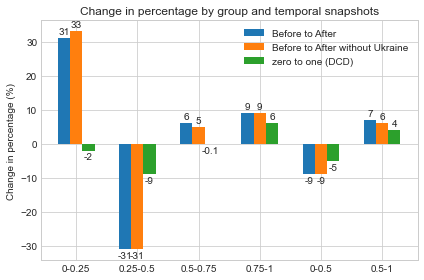

In [30]:
labels = ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1', '0-0.5','0.5-1']
BtA = [31, -31, 6, 9, -9, 7]
BtA_ucr = [33, -31, 5, 9, -9,6]
zerotoone= [-2,-9,-0.1,6,-5,4]

x = 3*np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, BtA, width, label='Before to After')
rects2 = ax.bar(x, BtA_ucr, width, label='Before to After without Ukraine')
rects3 = ax.bar(x + width, zerotoone, width, label='zero to one (DCD)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Change in percentage (%)')
ax.set_title('Change in percentage by group and temporal snapshots')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)

fig.tight_layout()

plt.show()

# Community Distribution

Lastly, it could be interesting to study how the user label distributes in each community through time. As shown in Figure \ref{community_distribution_5}, one can see that a community does not really represent a definite opinion. This behaviour is similar to the other distributions, and it is confirmed by the high variance and similar mean of each distribution. This is not surprising, since the community are build by topological assumption and not by taking in consideration the user label. This may be a hint that a community represents a topic, where users with different opinions interact with each others. Moreover, it can be noticed in Figure \ref{community_distribution_5} that the user label distribution appears to be stable through time, i.e. the changes of the bins are small.

In [31]:
#import dataset with the community label
df1 = pd.read_csv("../data_collection/data/RW_Graphs/df_S1_comm.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df2 = pd.read_csv("../data_collection/data/RW_Graphs/df_S2_comm.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df3 = pd.read_csv("../data_collection/data/RW_Graphs/df_S3_comm.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

df4 = pd.read_csv("../data_collection/data/RW_Graphs/df_S4_comm.csv", skipinitialspace=True, na_values='?', keep_default_na=True)

In [32]:
#same as above, but we keep track of the community
gb = df1.groupby(['User'])
counts = gb.size().to_frame(name='counts')
df1_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'})).join(gb.agg({'Community': pd.Series.mode}))
#df1_count['Community']=gb['Community']

#ignore timestamp, we keep just the value of the community
df1_count['Community'] = [x.strip()[-1] for x in df1_count['Community']]

gb = df2.groupby(['User'])
counts = gb.size().to_frame(name='counts')
df2_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'})).join(gb.agg({'Community': pd.Series.mode}))

df2_count['Community'] = [x.strip()[-1] for x in df2_count['Community']]


gb = df3.groupby(['User'])
counts = gb.size().to_frame(name='counts')
df3_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'})).join(gb.agg({'Community': pd.Series.mode}))

df3_count['Community'] = [x.strip()[-1] for x in df3_count['Community']]


gb = df4.groupby(['User'])
counts = gb.size().to_frame(name='counts')
df4_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'})).join(gb.agg({'Community': pd.Series.mode}))

df4_count['Community'] = [x.strip()[-1] for x in df4_count['Community']]


In [33]:
#same as above
N=2

df1_sorted=df1_count.loc[(df1_count['counts'] > N)]
df2_sorted=df2_count.loc[(df2_count['counts'] > N)]
df3_sorted=df3_count.loc[(df3_count['counts'] > N)]
df4_sorted=df4_count.loc[(df4_count['counts'] > N)]

In [34]:
def cre_dic(daf):
    '''Function that takes a dictionary as an input and returns a dictionary which has as key the community
    and as value the array of the user label of each member of the community'''
    
    community_list=daf['Community'].unique() #get names of the community in dictionary
    
    d={}

    for ele in community_list: #iterate over the communities of the dataset

        df1_ao=daf.loc[daf['Community'] == ele] #select just the community iterating
        d[ele]=df1_ao['user_label'].values #take all the values of the column user_label for that community
    return d

In [35]:
#create dictionary for every time stamp
d1=cre_dic(df1_sorted)
d2=cre_dic(df2_sorted)
d3=cre_dic(df3_sorted)
d4=cre_dic(df4_sorted)


In [36]:
#define a list of dictionary to create a dataframe
list_of_dict=[d1,d2,d3,d4]

In [37]:
#dataframe with the community and time stamps
df_temp = pd.DataFrame(list_of_dict)

do={}

for column in df_temp: #for every timestamp
    #create a dictionary which has as key the community and as label an array of arrays
    #of user label and time stamps
    do[column] = df_temp[column].values
    

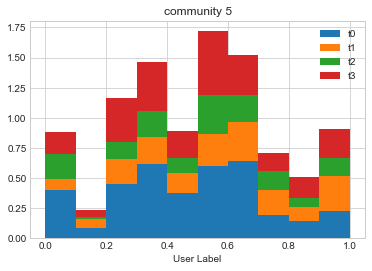

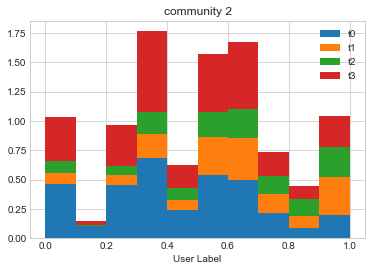

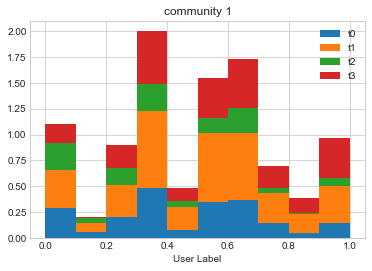

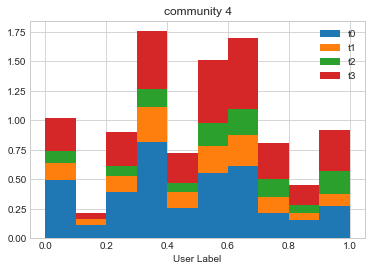

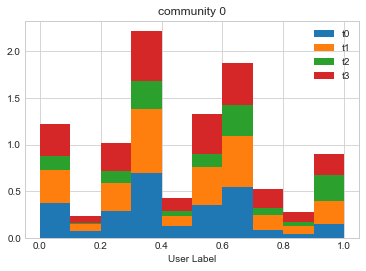

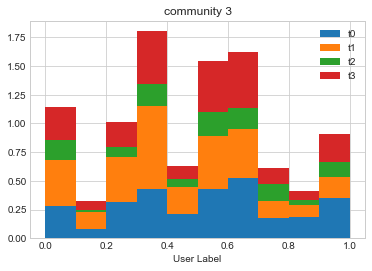

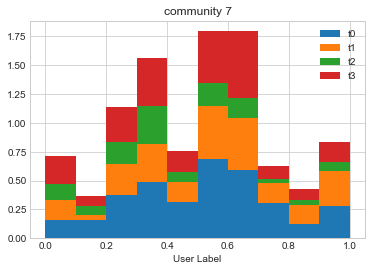

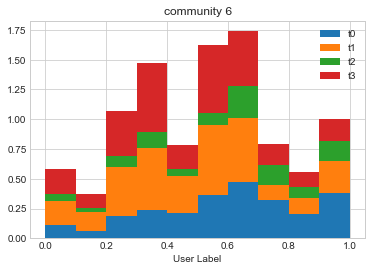

In [41]:
for key in list(do.keys())[:-1]:    #for every community
    plt.figure()
    #plot the distribution of user_label stacking the timestamps
    plt.hist(do[key], 10, stacked=True, density=True,label=['t0','t1','t2','t3'])
    plt.legend()
    plt.xlabel('User Label')
    plt.title('community {}'.format(key))
    plt.show()

In [42]:
#create other dictionaries in order to get distribution for every single community and time stamp (not stacked)
dfs4 = dict(tuple(df4_sorted.groupby('Community')))
dfs3 = dict(tuple(df3_sorted.groupby('Community')))
dfs2 = dict(tuple(df2_sorted.groupby('Community')))
dfs1 = dict(tuple(df1_sorted.groupby('Community')))


In [43]:
def create_bar_plot(dic_of_fr):
    for key,value in dic_of_fr.items():
        val_to_round=5*value.user_label #create five bins
        value.user_label=val_to_round.round()/5
        nuovo=value['user_label'].value_counts().sort_index()
        
        ax=nuovo.plot.bar(title=key)
        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel("Counts", fontsize=12)
        plt.show()

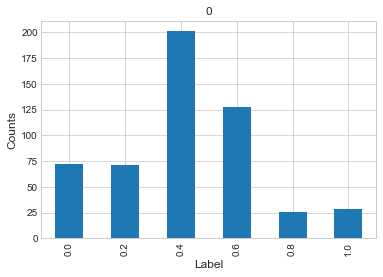

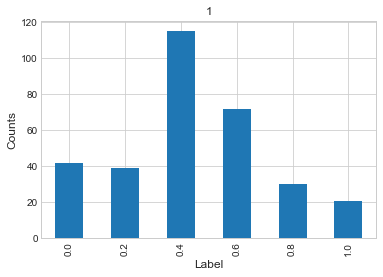

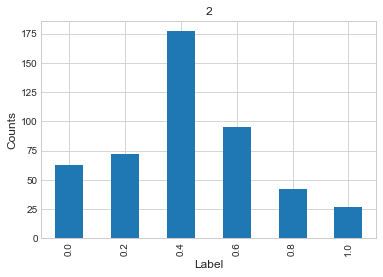

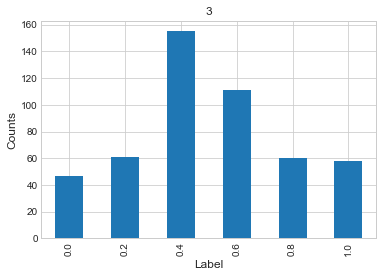

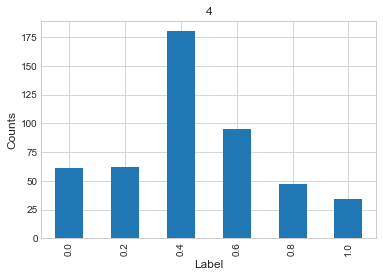

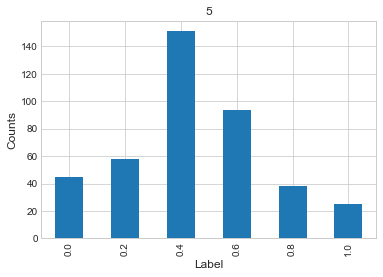

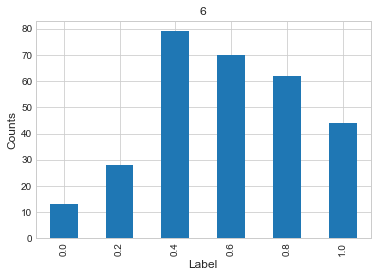

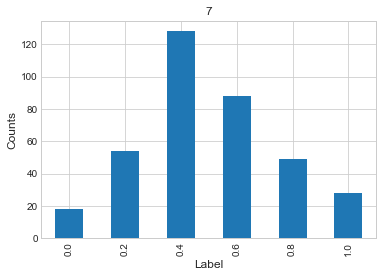

In [44]:
create_bar_plot(dfs1)

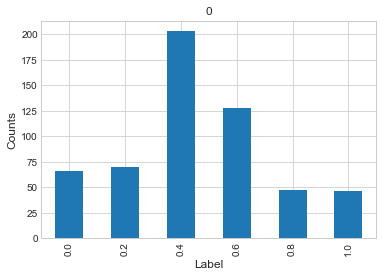

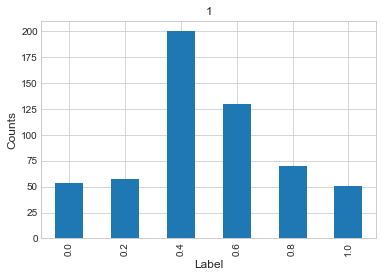

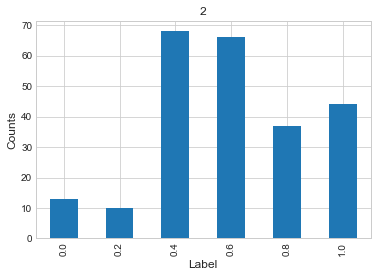

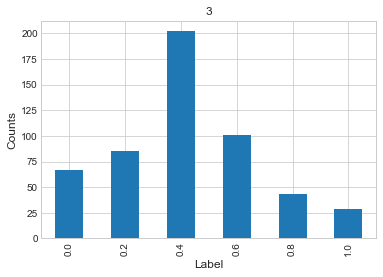

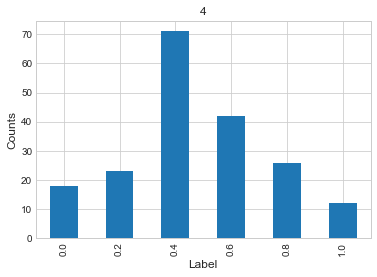

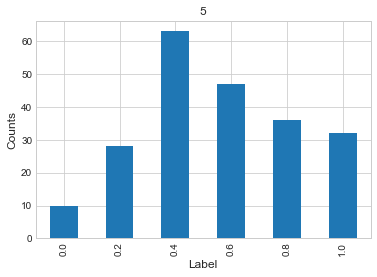

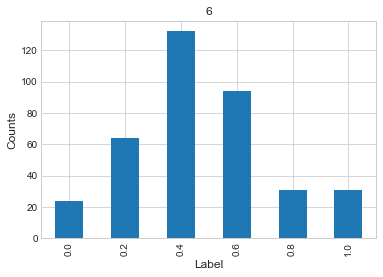

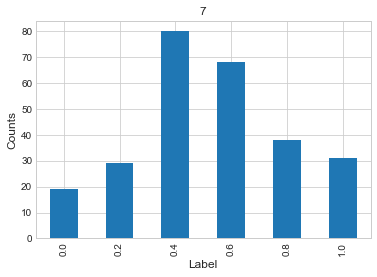

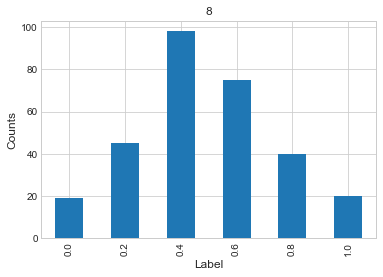

In [45]:
create_bar_plot(dfs2)

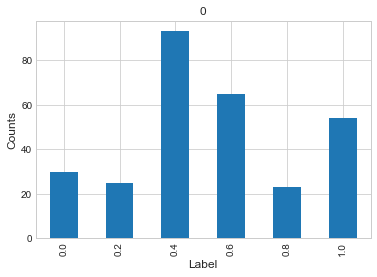

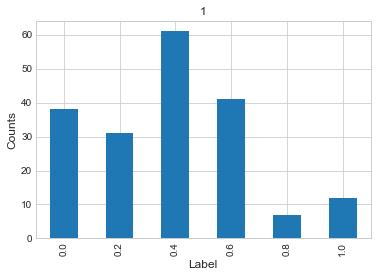

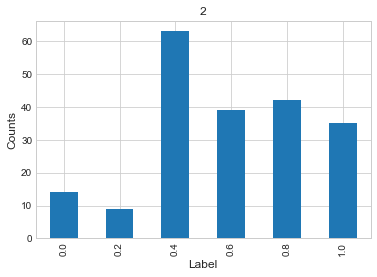

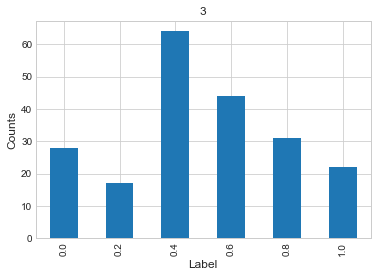

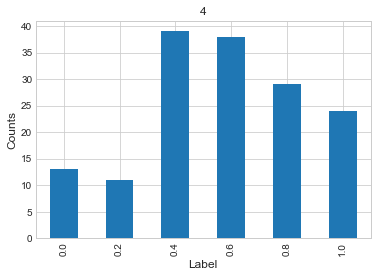

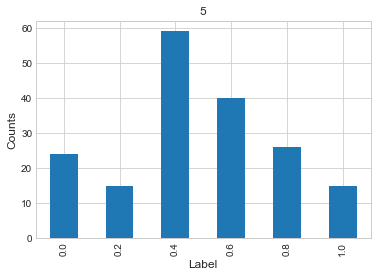

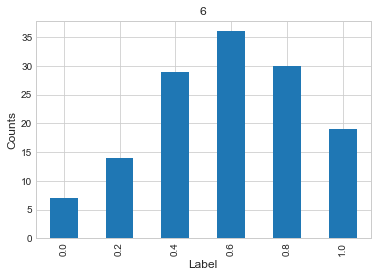

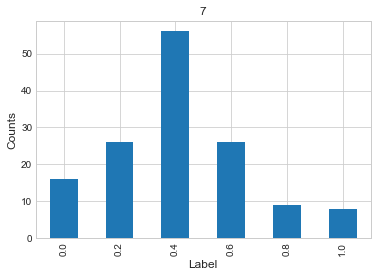

In [46]:
create_bar_plot(dfs3)

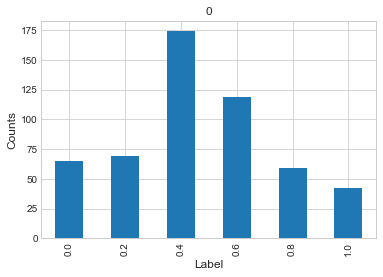

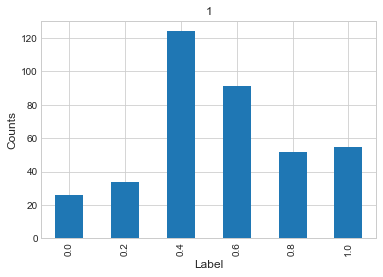

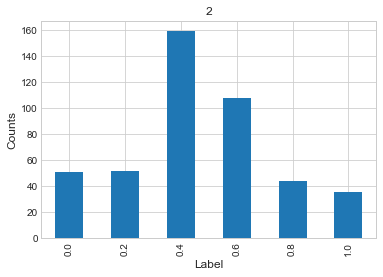

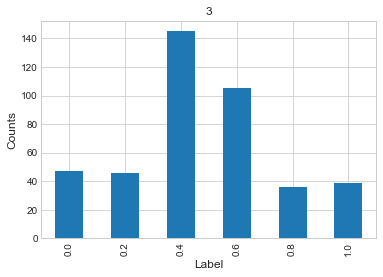

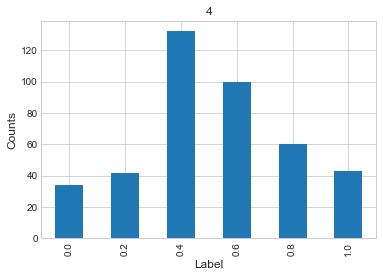

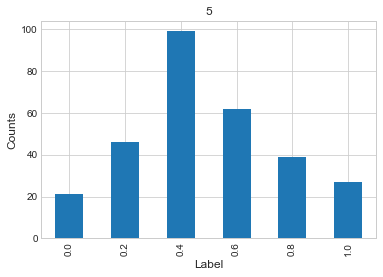

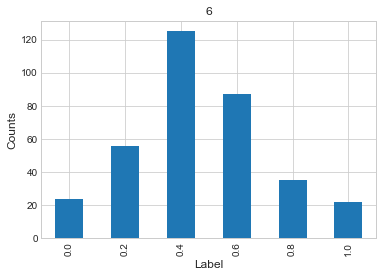

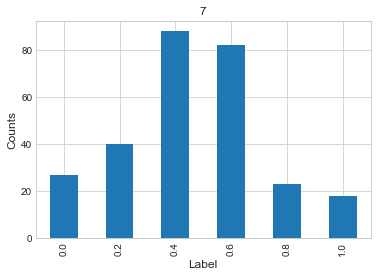

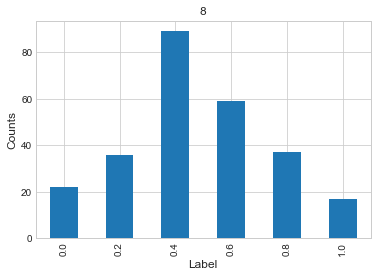

In [47]:
create_bar_plot(dfs4)

In [48]:
def stat_data(df1): 
    '''Function that take a dataframe as input and returns the statistics of user_label splitted by community'''
    
    #groupby user and compute user label as already did like 100 times 
    gb = df1.groupby(['User'])
    counts = gb.size().to_frame(name='counts')
    df_prestat=(counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'}))
               .join(gb.agg({'Community': pd.Series.mode}))
              )
    #same condition on the number of tweets per user
    N=2

    df_prestat=df_prestat.loc[(df_prestat['counts'] > N)]

    #group by community
    gb = df_prestat.groupby(['Community'])
    #count how many user in each community
    counts = gb.size().to_frame(name='counts')
    #get statistics of user label per community
    df_stat=(counts.join(gb.agg({'user_label': 'mean'}).rename(columns={'user_label': 'mean'}))
               .join(gb.agg({'user_label': 'std'}).rename(columns={'user_label': 'std'})) #standard deviation
               .join(gb.agg({'user_label': 'median'}).rename(columns={'user_label': 'median'}))
               #.join(gb.agg({'user_label': pd.Series.mode}).rename(columns={'user_label': 'mode'}))
               #.join(gb.agg({'Community': pd.Series.mode}))

              )
    return df_stat

In [49]:
stat_data(df1)

,counts,mean,std,median
Community,,,,
0,10,0.513333,0.345411,0.583333
1_0,517,0.423380,0.262916,0.333333
1_1,319,0.451890,0.275066,0.428571
1_2,476,0.431490,0.266328,0.400000
1_3,492,0.512698,0.288385,0.500000
1_4,479,0.451037,0.275223,0.416667
1_5,411,0.460349,0.261705,0.444444
1_6,296,0.595007,0.266870,0.666667
1_7,365,0.509393,0.250336,0.500000


In [50]:
stat_data(df2)

,counts,mean,std,median
Community,,,,
0,10,0.597727,0.345479,0.583333
2_0,550,0.460812,0.275530,0.400000
2_1,562,0.499394,0.272909,0.500000
2_2,238,0.611669,0.270160,0.666667
2_3,527,0.424483,0.263627,0.375000
2_4,192,0.479511,0.262329,0.500000
2_5,216,0.561852,0.277264,0.585714
2_6,376,0.482236,0.256782,0.500000
2_7,265,0.541185,0.271429,0.555556


In [51]:
stat_data(df3)

,counts,mean,std,median
Community,,,,
0,6,0.641026,0.353693,0.673077
3_0,284,0.537939,0.307693,0.500000
3_1,190,0.391663,0.284802,0.333333
3_2,202,0.598734,0.283341,0.666667
3_3,206,0.503160,0.292939,0.500000
3_4,154,0.572506,0.285936,0.625000
3_5,179,0.495428,0.282536,0.500000
3_6,135,0.594801,0.275040,0.666667
3_7,141,0.420261,0.257395,0.333333


In [52]:
stat_data(df4)

,counts,mean,std,median
Community,,,,
0,1,1.000000,NaN,1.000000
4_0,527,0.467982,0.279504,0.500000
4_1,382,0.551604,0.279370,0.594118
4_2,450,0.472595,0.273406,0.480769
4_3,418,0.486695,0.279731,0.500000
4_4,411,0.527027,0.274253,0.500000
4_5,294,0.499325,0.267074,0.500000
4_6,349,0.473197,0.251503,0.500000
4_7,278,0.475789,0.262179,0.500000


# Distribution of user_label based on tweet content

In [53]:
#get all dataset
df = pd.concat([df1, df2,df3,df4])

In [54]:
def stat_data_ucr(df1): 
    '''Function that take a dataframe as input and returns the statistics of user_label if the tweet are about Ukraine'''
    

    #group by ukr
    gb = df1.groupby(['ukr'])
    #count how many user in each community
    counts = gb.size().to_frame(name='counts')
    #get statistics of user label per community
    df_stat=(counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'mean'}))
               .join(gb.agg({'tweet_label': 'std'}).rename(columns={'tweet_label': 'std'})) #standard deviation
               .join(gb.agg({'tweet_label': 'median'}).rename(columns={'tweet_label': 'median'}))
               #.join(gb.agg({'user_label': pd.Series.mode}).rename(columns={'user_label': 'mode'}))
               #.join(gb.agg({'Community': pd.Series.mode}))

              )
    return df_stat

In [55]:
stat_data_ucr(df)

,counts,mean,std,median
ukr,,,,
0,131069,0.509152,0.499918,1.0
1,808,0.716584,0.450936,1.0


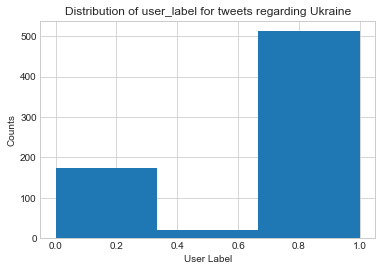

In [56]:
#create a histogram of user label if the tweets concern Ukraine
df_ucr = df[df['ukr'] == 1]
gb = df_ucr.groupby(['User'])
counts = gb.size().to_frame(name='counts')
df1_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'}))
df1_count=df1_count.loc[(df1_count['counts'] >= 1)]
plt.hist(df1_count['user_label'],bins=3)
plt.title('Distribution of user_label for tweets regarding Ukraine')
plt.xlabel('User Label')
plt.ylabel('Counts')
plt.savefig("./plots/ucr3.pdf")
plt.show()

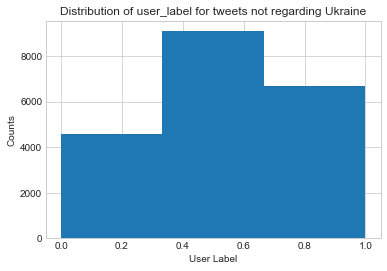

In [57]:
#histogram if the tweet are not about Ukraine
df_rest= df[df['ukr'] == 0]
gb = df_rest.groupby(['User'])
counts = gb.size().to_frame(name='counts')
df1_count=counts.join(gb.agg({'tweet_label': 'mean'}).rename(columns={'tweet_label': 'user_label'}))
df1_count=df1_count.loc[(df1_count['counts'] >= 2)]
plt.hist(df1_count['user_label'],bins=3)
plt.title('Distribution of user_label for tweets not regarding Ukraine')
plt.xlabel('User Label')
plt.ylabel('Counts')
plt.savefig("./plots/rest3.pdf")
plt.show()